In [1]:
import os
os.nice(10)
import datetime as dt
import pandas as pd
import numpy as np
import xarray as xr
import configparser


import modules.load_data as ld


#######################################################################
# paths
config = configparser.ConfigParser()
config.read("ConfigFile.ini")
pf = config['PATHS']['datasets']


# This dataset is produced by "make_dataset_ecrad_skill.py"
# In this dataset the simulated irradiance with and without aerosols
# by T-CARS is stored, collocated to the DWD stations.
# From this, the T-CARS broadband AOD will be calculated
fname_TCARS_irradiance = os.path.join(pf,"ecrad_dwd_skill.nc")

# This dataset is produced by "make_dataset_CSF.py"
# The dataset stores the clear sky fitted irradiance with one CSM
# and the AOD inverted from the CSM
fname_CSF = os.path.join(pf,'CSF/{model}_{station}.nc')



##########################################################################
# settings
dates = pd.date_range("2015-01-01","2015-12-31")
stations = ld.dwd_stations()
# we drop Zugspitze, since data is not available complete 2015
stations = stations.drop_sel(station='ZG')
# CSM names
models = np.array(['MRM61',
                  'MMAC',
                  'Heliosat1I',
                  'CEM',
                  'ESRA',
                  'METSTAT',
                  'SOLISsimple'])




In [2]:
CSF = xr.open_dataset(fname_CSF.format(model='MMAC',station='AK'))
CSF

<xarray.Dataset>
Dimensions:  (time: 87840)
Coordinates:
  * time     (time) datetime64[ns] 2015-02-05 ... 2015-12-30T23:59:00
Data variables:
    aod0     (time) float64 ...
    mdni0    (time) float64 ...
    mdhi0    (time) float64 ...
    mghi0    (time) float64 ...
    mdni     (time) float64 ...
    mdhi     (time) float64 ...
    mghi     (time) float64 ...

In [3]:
BB = xr.open_dataset(fname_TCARS_irradiance)
BB = BB.where(BB.mu0>0,drop=True)
BB

<xarray.Dataset>
Dimensions:  (col: 103916, tag: 7)
Coordinates:
  * col      (col) int64 0 1 2 3 4 5 ... 102831 102832 102833 102834 102835
    time     (col) datetime64[ns] 2015-02-05T08:13:00 ... 2015-11-06T10:36:00
    mu0      (col) float64 0.1558 0.1576 0.1594 0.2088 ... 0.4442 0.4445 0.4448
  * tag      (tag) object 'mountain' 'shore' 'north' 'south' 'cfb' 'dfb' 'dfc'
Data variables:
    glo_obs  (col) float64 129.0 130.0 132.0 176.0 ... 488.0 489.0 489.0 490.0
    glo_aer  (col) float32 134.8 136.7 138.6 184.8 ... 478.9 479.3 479.7 480.0
    glo_clr  (col) float32 140.5 142.4 144.3 200.4 ... 481.1 481.5 481.8 482.2
    dni_obs  (col) float64 556.1 556.2 562.7 ... 1.002e+03 1.001e+03 1.003e+03
    dni_aer  (col) float64 645.4 648.8 652.1 661.5 ... 989.2 989.4 989.6 989.7
    dni_clr  (col) float64 706.9 710.0 713.1 791.0 ... 999.6 999.7 999.9 1e+03
    mask     (col, tag) float64 0.0 1.0 1.0 0.0 1.0 0.0 ... 0.0 1.0 0.0 0.0 1.0
    name     (col) object 'AK' 'AK' 'AK' 'AK' 'AK' ... 'ZG' 'ZG' 'ZG' 'ZG' 'ZG'

DatetimeIndex(['2015-02-05', '2015-02-26', '2015-02-27', '2015-03-08',
               '2015-03-09', '2015-03-11', '2015-03-16', '2015-03-18',
               '2015-03-19', '2015-04-03', '2015-04-04', '2015-04-05',
               '2015-04-17', '2015-04-18', '2015-04-19', '2015-04-20',
               '2015-04-21', '2015-05-01', '2015-05-02', '2015-05-14',
               '2015-05-21', '2015-06-04', '2015-06-05', '2015-06-07',
               '2015-06-09', '2015-06-10', '2015-06-11', '2015-06-12',
               '2015-06-14', '2015-06-20', '2015-07-01', '2015-07-02',
               '2015-07-03', '2015-07-04', '2015-07-07', '2015-07-11',
               '2015-07-14', '2015-07-15', '2015-07-18', '2015-07-21',
               '2015-07-26', '2015-08-03', '2015-08-04', '2015-08-09',
               '2015-08-13', '2015-08-14', '2015-08-18', '2015-08-19',
               '2015-08-20', '2015-08-21', '2015-09-28', '2015-09-30',
               '2015-12-30'],
              dtype='datetime64[ns]', freq=None

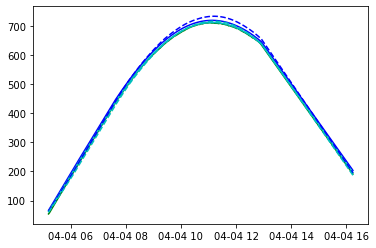

In [8]:
station = 'AK'
model = 'ESRA'
idate = 10

BB = xr.open_dataset(fname_TCARS_irradiance)
BB = BB.where(BB.mu0>0,drop=True)
BBsel = BB.where(BB.dni_clr>0,drop=True)
BBsel = BBsel.where(BBsel.dni_aer>0,drop=True)
BBsel = BBsel.where(BBsel.name==station,drop=True)
BBsel = BBsel.swap_dims({'col':'time'})
udates = pd.to_datetime(np.unique(BBsel.time.values.astype('datetime64[D]')))
print(udates)
BBsel = BBsel.sel(time=udates[idate].strftime("%Y-%m-%d"))

CSF = xr.open_dataset(fname_CSF.format(model=model,station=station))
CSF = CSF.reindex_like(BBsel)

plt.plot(BBsel.time,BBsel.glo_obs,'g')
plt.plot(BBsel.time,BBsel.glo_clr,'b')
plt.plot(BBsel.time,BBsel.glo_aer,'c')
plt.plot(CSF.time,CSF.mghi0,'b--')
plt.plot(CSF.time,CSF.mghi,'c--')

In [24]:

# initialyze result dataset
TGLO0 = np.array([])
TDNI0 = np.array([])
TGLO = np.array([])
TDNI = np.array([])
OGLO = np.array([])
ODNI = np.array([])
for m,model in enumerate(models):
    globals()[f"CGLO0_{model}"]=np.array([])
    globals()[f"CDNI0_{model}"]=np.array([])
    globals()[f"CGLO_{model}"]=np.array([])
    globals()[f"CDNI_{model}"]=np.array([])

# load T-CARS
BB = xr.open_dataset(fname_TCARS_irradiance)
BB = BB.where(BB.mu0>0,drop=True)
BB = BB.where(BB.dni_clr>0,drop=True)
BB = BB.where(BB.dni_aer>0,drop=True)
BB = BB.swap_dims({'col':'time'})

for s,station in enumerate(stations.station.values[:]):
    BBsel = BB.where(BB.name==station,drop=True)
#     BBday = BBsel.resample(time="1D").mean(skipna=True)
    
    TGLO0 = np.concatenate((TGLO0,BBsel.glo_clr.values), axis=0)
    TDNI0 = np.concatenate((TDNI0,BBsel.dni_clr.values), axis=0)   
    TGLO = np.concatenate((TGLO,BBsel.glo_aer.values), axis=0)
    TDNI = np.concatenate((TDNI,BBsel.dni_aer.values), axis=0)
    OGLO = np.concatenate((OGLO,BBsel.glo_obs.values), axis=0)
    ODNI = np.concatenate((ODNI,BBsel.dni_obs.values), axis=0)
#     TGLO0 = np.concatenate((TGLO0,BBday.glo_clr.values), axis=0)
#     TDNI0 = np.concatenate((TDNI0,BBday.dni_clr.values), axis=0)   
#     TGLO = np.concatenate((TGLO,BBday.glo_aer.values), axis=0)
#     TDNI = np.concatenate((TDNI,BBday.dni_aer.values), axis=0)
#     OGLO = np.concatenate((OGLO,BBday.glo_obs.values), axis=0)
#     ODNI = np.concatenate((ODNI,BBday.dni_obs.values), axis=0)
    for m,model in enumerate(models):
        CSF = xr.open_dataset(fname_CSF.format(model=model,station=station))
        CSF = CSF.reindex_like(BBsel)
#         CSF = CSF.resample(time="1D").mean(skipna=True)
        globals()[f"CGLO0_{model}"] = np.concatenate((globals()[f"CGLO0_{model}"],CSF.mghi0.values),axis=0)
        globals()[f"CDNI0_{model}"] = np.concatenate((globals()[f"CDNI0_{model}"],CSF.mdni0.values),axis=0)
        globals()[f"CGLO_{model}"] = np.concatenate((globals()[f"CGLO_{model}"],CSF.mghi.values),axis=0)
        globals()[f"CDNI_{model}"] = np.concatenate((globals()[f"CDNI_{model}"],CSF.mdni.values),axis=0)
 



In [28]:
# for daily means
# initialyze result dataset
MTGLO0 = np.array([])
MTDNI0 = np.array([])
MTGLO = np.array([])
MTDNI = np.array([])
MOGLO = np.array([])
MODNI = np.array([])
for m,model in enumerate(models):
    globals()[f"MCGLO0_{model}"]=np.array([])
    globals()[f"MCDNI0_{model}"]=np.array([])
    globals()[f"MCGLO_{model}"]=np.array([])
    globals()[f"MCDNI_{model}"]=np.array([])

# load T-CARS
BB = xr.open_dataset(fname_TCARS_irradiance)
BB = BB.where(BB.mu0>0,drop=True)
BB = BB.where(BB.dni_clr>0,drop=True)
BB = BB.where(BB.dni_aer>0,drop=True)
BB = BB.swap_dims({'col':'time'})

for s,station in enumerate(stations.station.values[:]):
    BBsel = BB.where(BB.name==station,drop=True)
    BBday = BBsel.resample(time="1D").mean(skipna=True)

    MTGLO0 = np.concatenate((MTGLO0,BBday.glo_clr.values), axis=0)
    MTDNI0 = np.concatenate((MTDNI0,BBday.dni_clr.values), axis=0)   
    MTGLO = np.concatenate((MTGLO,BBday.glo_aer.values), axis=0)
    MTDNI = np.concatenate((MTDNI,BBday.dni_aer.values), axis=0)
    MOGLO = np.concatenate((MOGLO,BBday.glo_obs.values), axis=0)
    MODNI = np.concatenate((MODNI,BBday.dni_obs.values), axis=0)
    for m,model in enumerate(models):
        CSF = xr.open_dataset(fname_CSF.format(model=model,station=station))
        CSF = CSF.reindex_like(BBsel)
        CSF = CSF.resample(time="1D").mean(skipna=True)
        globals()[f"MCGLO0_{model}"] = np.concatenate((globals()[f"MCGLO0_{model}"],CSF.mghi0.values),axis=0)
        globals()[f"MCDNI0_{model}"] = np.concatenate((globals()[f"MCDNI0_{model}"],CSF.mdni0.values),axis=0)
        globals()[f"MCGLO_{model}"] = np.concatenate((globals()[f"MCGLO_{model}"],CSF.mghi.values),axis=0)
        globals()[f"MCDNI_{model}"] = np.concatenate((globals()[f"MCDNI_{model}"],CSF.mdni.values),axis=0)
 


In [37]:
from modules.modules_FIG03 import *

print()
print("pristine CSM vs TCARS")
print("model            Annual Mean   MBE   RMSE correlation linear regression")
print("\\multirow{7}{*}{\\rotatebox[origin=c]{90}{GLO$_\\mathrm{pri}$}}")
# print("GHI")
msort=[0,4,2,6,3,1,5]
for m,model in enumerate(models[msort]):
    X = TGLO0
    Y = globals()[f"CGLO0_{model}"]
    idx = ~np.isnan(X)*~np.isinf(X)
    idx*= ~np.isnan(Y)*~np.isinf(Y)
    X = X[idx]
    Y = Y[idx]
    A = np.vstack([X, np.ones(len(X))]).T
    m, c = np.linalg.lstsq(A, Y, rcond=None)[0]    
    corr=np.corrcoef(X,Y)[0,1]
    N= len(Y)
    MBE,MABE,RMSE,FB,FGE = get_metrics(X,Y)
    print(f"& {model:15} & {np.mean(Y):.0f} & {MBE:6.2f} & {RMSE:6.2f} & {corr:5.2f} & {c: 6.2f} + {m:.2f}\,$X$ \\\\")
print()
# print('DNI')
print("\\multirow{7}{*}{\\rotatebox[origin=c]{90}{DNI$_\\mathrm{pri}$}}")
msort=[0,4,2,6,3,1,5]
for m,model in enumerate(models[msort]):
    X = TDNI0
    Y = globals()[f"CDNI0_{model}"]
    idx = ~np.isnan(X)*~np.isinf(X)
    idx*= ~np.isnan(Y)*~np.isinf(Y)
    X = X[idx]
    Y = Y[idx]
    A = np.vstack([X, np.ones(len(X))]).T
    m, c = np.linalg.lstsq(A, Y, rcond=None)[0]  
    corr=np.corrcoef(X,Y)[0,1]
    N= len(Y)
    MBE,MABE,RMSE,FB,FGE = get_metrics(X,Y)
    print(f"& {model:15} & {np.mean(Y):.0f}  & {MBE:6.2f} & {RMSE:6.2f} & {corr:5.2f} & {c: 6.2f} + {m:.2f}\,$X$ \\\\")

print()
print("Model vs OBS - with aerosol")

print("\\multirow{7}{*}{\\rotatebox[origin=c]{90}{GLO}}")
# print("GHI")
msort=[0,4,2,6,3,1,5]
for m,model in enumerate(models[msort]):
    X = OGLO
    Y = globals()[f"CGLO_{model}"]
    idx = ~np.isnan(X)*~np.isinf(X)
    idx*= ~np.isnan(Y)*~np.isinf(Y)
    X = X[idx]
    Y = Y[idx]
    A = np.vstack([X, np.ones(len(X))]).T
    m, c = np.linalg.lstsq(A, Y, rcond=None)[0]    
    corr=np.corrcoef(X,Y)[0,1]
    N= len(Y)
    MBE,MABE,RMSE,FB,FGE = get_metrics(X,Y)
    print(f"& {model:15} & {np.mean(Y):.0f} & {MBE:6.2f} & {RMSE:6.2f} & {corr:5.2f} & {c: 6.2f} + {m:.2f}\,$X$ \\\\")
X = OGLO
Y = TGLO
idx = ~np.isnan(X)*~np.isinf(X)
idx*= ~np.isnan(Y)*~np.isinf(Y)
X = X[idx]
Y = Y[idx]
A = np.vstack([X, np.ones(len(X))]).T
m, c = np.linalg.lstsq(A, Y, rcond=None)[0]  
corr=np.corrcoef(X,Y)[0,1]
N= len(Y)
MBE,MABE,RMSE,FB,FGE = get_metrics(X,Y)
print(f"& {'TCARS':15} & {np.mean(Y):.0f}  & {MBE:6.2f} & {RMSE:6.2f} & {corr:5.2f} & {c: 6.2f} + {m:.2f}\,$X$ \\\\")
print()
print("\\multirow{7}{*}{\\rotatebox[origin=c]{90}{DNI}}")
# print("DNI")
msort=[0,4,2,6,3,1,5]
for m,model in enumerate(models[msort]):
    X = ODNI
    Y = globals()[f"CDNI_{model}"]
    idx = ~np.isnan(X)*~np.isinf(X)
    idx*= ~np.isnan(Y)*~np.isinf(Y)
    X = X[idx]
    Y = Y[idx]
    A = np.vstack([X, np.ones(len(X))]).T
    m, c = np.linalg.lstsq(A, Y, rcond=None)[0]  
    corr=np.corrcoef(X,Y)[0,1]
    N= len(Y)
    MBE,MABE,RMSE,FB,FGE = get_metrics(X,Y)
    print(f"& {model:15} & {np.mean(Y):.0f}  & {MBE:6.2f} & {RMSE:6.2f} & {corr:5.2f} & {c: 6.2f} + {m:.2f}\,$X$ \\\\")
X = ODNI
Y = TDNI
idx = ~np.isnan(X)*~np.isinf(X)
idx*= ~np.isnan(Y)*~np.isinf(Y)
X = X[idx]
Y = Y[idx]
A = np.vstack([X, np.ones(len(X))]).T
m, c = np.linalg.lstsq(A, Y, rcond=None)[0]  
corr=np.corrcoef(X,Y)[0,1]
N= len(Y)
MBE,MABE,RMSE,FB,FGE = get_metrics(X,Y)
print(f"& {'TCARS':15} & {np.mean(Y):.0f}  & {MBE:6.2f} & {RMSE:6.2f} & {corr:5.2f} & {c: 6.2f} + {m:.2f}\,$X$ \\\\")


pristine CSM vs TCARS
model            Annual Mean   MBE   RMSE correlation linear regression
\multirow{7}{*}{\rotatebox[origin=c]{90}{GLO$_\mathrm{pri}$}}
& MRM61           & 472 &   5.89 &   7.45 &  1.00 &   3.96 + 1.00\,$X$ \\
& ESRA            & 474 &  14.67 &  23.45 &  1.00 & -13.92 + 1.06\,$X$ \\
& Heliosat1I      & 466 &   6.93 &  17.65 &  1.00 & -17.37 + 1.05\,$X$ \\
& SOLISsimple     & 461 &   1.15 &   3.76 &  1.00 &   0.03 + 1.00\,$X$ \\
& CEM             & 498 &  31.82 &  35.39 &  1.00 &   5.55 + 1.06\,$X$ \\
& MMAC            & 467 &   0.78 &   4.15 &  1.00 &  -2.36 + 1.01\,$X$ \\
& METSTAT         & 456 &  -9.45 &  11.21 &  1.00 &  -8.60 + 1.00\,$X$ \\

\multirow{7}{*}{\rotatebox[origin=c]{90}{DNI$_\mathrm{pri}$}}
& MRM61           & 864  &  28.90 &  46.42 &  1.00 &  196.75 + 0.80\,$X$ \\
& ESRA            & 823  & -11.55 &  33.24 &  0.99 & -63.04 + 1.06\,$X$ \\
& Heliosat1I      & 820  & -15.11 &  34.76 &  0.99 & -79.50 + 1.08\,$X$ \\
& SOLISsimple     & 840  &   5.59 & 

In [35]:
from modules.modules_FIG03 import *
print("DAILY MEANS")
print()
print("pristine CSM vs TCARS")
print("model            Annual Mean   MBE   RMSE correlation linear regression")
# print("\\multirow{7}{*}{\\rotatebox[origin=c]{90}{GLO$_\\mathrm{pri}$}}")
print("GHI")
msort=[0,4,2,6,3,1,5]
for m,model in enumerate(models[msort]):
    X = MTGLO0
    Y = globals()[f"MCGLO0_{model}"]
    idx = ~np.isnan(X)*~np.isinf(X)
    idx*= ~np.isnan(Y)*~np.isinf(Y)
    X = X[idx]
    Y = Y[idx]
    A = np.vstack([X, np.ones(len(X))]).T
    m, c = np.linalg.lstsq(A, Y, rcond=None)[0]    
    corr=np.corrcoef(X,Y)[0,1]
    N= len(Y)
    MBE,MABE,RMSE,FB,FGE = get_metrics(X,Y)
    print(f"& {model:15} & {np.mean(Y):.0f} & {MBE:6.2f} & {RMSE:6.2f} & {corr:5.2f} & {c: 6.2f} + {m:.2f}\,$X$ \\\\")
print()
print('DNI')
# print("\\multirow{7}{*}{\\rotatebox[origin=c]{90}{DNI$_\\mathrm{pri}$}}")
msort=[0,4,2,6,3,1,5]
for m,model in enumerate(models[msort]):
    X = MTDNI0
    Y = globals()[f"MCDNI0_{model}"]
    idx = ~np.isnan(X)*~np.isinf(X)
    idx*= ~np.isnan(Y)*~np.isinf(Y)
    X = X[idx]
    Y = Y[idx]
    A = np.vstack([X, np.ones(len(X))]).T
    m, c = np.linalg.lstsq(A, Y, rcond=None)[0]  
    corr=np.corrcoef(X,Y)[0,1]
    N= len(Y)
    MBE,MABE,RMSE,FB,FGE = get_metrics(X,Y)
    print(f"& {model:15} & {np.mean(Y):.0f}  & {MBE:6.2f} & {RMSE:6.2f} & {corr:5.2f} & {c: 6.2f} + {m:.2f}\,$X$ \\\\")
# print()
# print("CSM vs TCARS")
# print()
# print("\\multirow{7}{*}{\\rotatebox[origin=c]{90}{GLO}}")
# msort=[0,4,2,6,3,1,5]
# for m,model in enumerate(models[msort]):
#     X = MTGLO
#     Y = globals()[f"MCGLO_{model}"]
#     idx = ~np.isnan(X)*~np.isinf(X)
#     idx*= ~np.isnan(Y)*~np.isinf(Y)
#     X = X[idx]
#     Y = Y[idx]
#     A = np.vstack([X, np.ones(len(X))]).T
#     m, c = np.linalg.lstsq(A, Y, rcond=None)[0]    
#     corr=np.corrcoef(X,Y)[0,1]
#     N= len(Y)
#     MBE,MABE,RMSE,FB,FGE = get_metrics(X,Y)
#     print(f"& {model:15} & {np.mean(Y):.0f} & {MBE:6.2f} & {RMSE:6.2f} & {corr:5.2f} & {c: 6.2f} + {m:.2f}\,$X$ \\\\")
# print()
# print("\\multirow{7}{*}{\\rotatebox[origin=c]{90}{DNI}}")
# msort=[0,4,2,6,3,1,5]
# for m,model in enumerate(models[msort]):
#     X = MTDNI
#     Y = globals()[f"MCDNI_{model}"]
#     idx = ~np.isnan(X)*~np.isinf(X)
#     idx*= ~np.isnan(Y)*~np.isinf(Y)
#     X = X[idx]
#     Y = Y[idx]
#     A = np.vstack([X, np.ones(len(X))]).T
#     m, c = np.linalg.lstsq(A, Y, rcond=None)[0]  
#     corr=np.corrcoef(X,Y)[0,1]
#     N= len(Y)
#     MBE,MABE,RMSE,FB,FGE = get_metrics(X,Y)
#     print(f"& {model:15} & {np.mean(Y):.0f}  & {MBE:6.2f} & {RMSE:6.2f} & {corr:5.2f} & {c: 6.2f} + {m:.2f}\,$X$ \\\\")

print()
print("Model vs OBS - with aerosol")

# print("\\multirow{7}{*}{\\rotatebox[origin=c]{90}{GLO}}")
print("GHI")
msort=[0,4,2,6,3,1,5]
for m,model in enumerate(models[msort]):
    X = MOGLO
    Y = globals()[f"MCGLO_{model}"]
    idx = ~np.isnan(X)*~np.isinf(X)
    idx*= ~np.isnan(Y)*~np.isinf(Y)
    X = X[idx]
    Y = Y[idx]
    A = np.vstack([X, np.ones(len(X))]).T
    m, c = np.linalg.lstsq(A, Y, rcond=None)[0]    
    corr=np.corrcoef(X,Y)[0,1]
    N= len(Y)
    MBE,MABE,RMSE,FB,FGE = get_metrics(X,Y)
    print(f"& {model:15} & {np.mean(Y):.0f} & {MBE:6.2f} & {RMSE:6.2f} & {corr:5.2f} & {c: 6.2f} + {m:.2f}\,$X$ \\\\")
X = MOGLO
Y = MTGLO
idx = ~np.isnan(X)*~np.isinf(X)
idx*= ~np.isnan(Y)*~np.isinf(Y)
X = X[idx]
Y = Y[idx]
A = np.vstack([X, np.ones(len(X))]).T
m, c = np.linalg.lstsq(A, Y, rcond=None)[0]  
corr=np.corrcoef(X,Y)[0,1]
N= len(Y)
MBE,MABE,RMSE,FB,FGE = get_metrics(X,Y)
print(f"& {'TCARS':15} & {np.mean(Y):.0f}  & {MBE:6.2f} & {RMSE:6.2f} & {corr:5.2f} & {c: 6.2f} + {m:.2f}\,$X$ \\\\")
print()
# print("\\multirow{7}{*}{\\rotatebox[origin=c]{90}{DNI}}")
print("DNI")
msort=[0,4,2,6,3,1,5]
for m,model in enumerate(models[msort]):
    X = MODNI
    Y = globals()[f"MCDNI_{model}"]
    idx = ~np.isnan(X)*~np.isinf(X)
    idx*= ~np.isnan(Y)*~np.isinf(Y)
    X = X[idx]
    Y = Y[idx]
    A = np.vstack([X, np.ones(len(X))]).T
    m, c = np.linalg.lstsq(A, Y, rcond=None)[0]  
    corr=np.corrcoef(X,Y)[0,1]
    N= len(Y)
    MBE,MABE,RMSE,FB,FGE = get_metrics(X,Y)
    print(f"& {model:15} & {np.mean(Y):.0f}  & {MBE:6.2f} & {RMSE:6.2f} & {corr:5.2f} & {c: 6.2f} + {m:.2f}\,$X$ \\\\")
X = MODNI
Y = MTDNI
idx = ~np.isnan(X)*~np.isinf(X)
idx*= ~np.isnan(Y)*~np.isinf(Y)
X = X[idx]
Y = Y[idx]
A = np.vstack([X, np.ones(len(X))]).T
m, c = np.linalg.lstsq(A, Y, rcond=None)[0]  
corr=np.corrcoef(X,Y)[0,1]
N= len(Y)
MBE,MABE,RMSE,FB,FGE = get_metrics(X,Y)
print(f"& {'TCARS':15} & {np.mean(Y):.0f}  & {MBE:6.2f} & {RMSE:6.2f} & {corr:5.2f} & {c: 6.2f} + {m:.2f}\,$X$ \\\\")
    
    
    




DAILY MEANS

pristine CSM vs TCARS
model            Annual Mean   MBE   RMSE correlation linear regression
GHI
& MRM61           & 354 &   5.16 &   6.34 &  1.00 &   3.50 + 1.00\,$X$ \\
& ESRA            & 351 &   7.45 &  15.19 &  1.00 & -14.19 + 1.06\,$X$ \\
& Heliosat1I      & 345 &   0.90 &  11.70 &  1.00 & -17.42 + 1.05\,$X$ \\
& SOLISsimple     & 345 &   0.90 &   2.77 &  1.00 &   0.42 + 1.00\,$X$ \\
& CEM             & 374 &  25.06 &  27.42 &  1.00 &   5.16 + 1.06\,$X$ \\
& MMAC            & 349 &  -0.01 &   3.04 &  1.00 &  -2.44 + 1.01\,$X$ \\
& METSTAT         & 339 &  -9.53 &  10.75 &  1.00 &  -9.37 + 1.00\,$X$ \\

DNI
& MRM61           & 811  &  39.95 &  46.70 &  1.00 &  186.45 + 0.81\,$X$ \\
& ESRA            & 752  & -18.74 &  28.60 &  0.99 & -100.02 + 1.11\,$X$ \\
& Heliosat1I      & 748  & -23.14 &  32.15 &  0.99 & -114.01 + 1.12\,$X$ \\
& SOLISsimple     & 782  &  11.01 &  16.42 &  1.00 &  75.39 + 0.92\,$X$ \\
& CEM             & 791  &  19.32 &  25.54 &  1.00 & -60.68 + 1

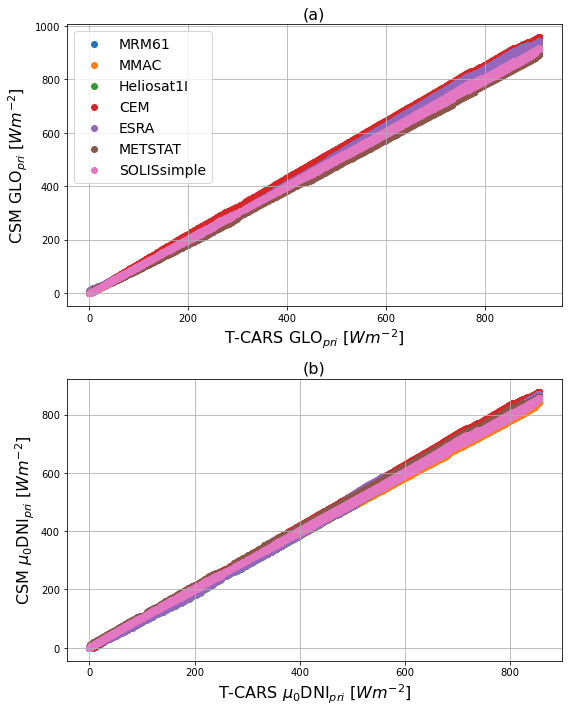

In [3]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
for m,model in enumerate(models):
    ax1.scatter(TGLO0,globals()[f"CGLO0_{model}"],label=model)
    ax2.scatter(TDNI0,globals()[f"CDNI0_{model}"],label=model)


ax1.set_title('(a)',fontsize = 16)
ax1.legend(fontsize=14)
ax1.grid(True)
ax1.set_xlabel(r'T-CARS GLO$_{pri}$ $\left[Wm^{-2}\right]$',fontsize = 16)
ax1.set_ylabel(r'CSM GLO$_{pri}$ $\left[Wm^{-2}\right]$',fontsize = 16)


ax2.set_title('(b)',fontsize = 16)
ax2.grid(True)
ax2.set_xlabel(r'T-CARS $\mu_0$DNI$_{pri}$ $\left[Wm^{-2}\right]$',fontsize = 16)
ax2.set_ylabel(r'CSM $\mu_0$DNI$_{pri}$ $\left[Wm^{-2}\right]$',fontsize = 16)
plt.tight_layout()

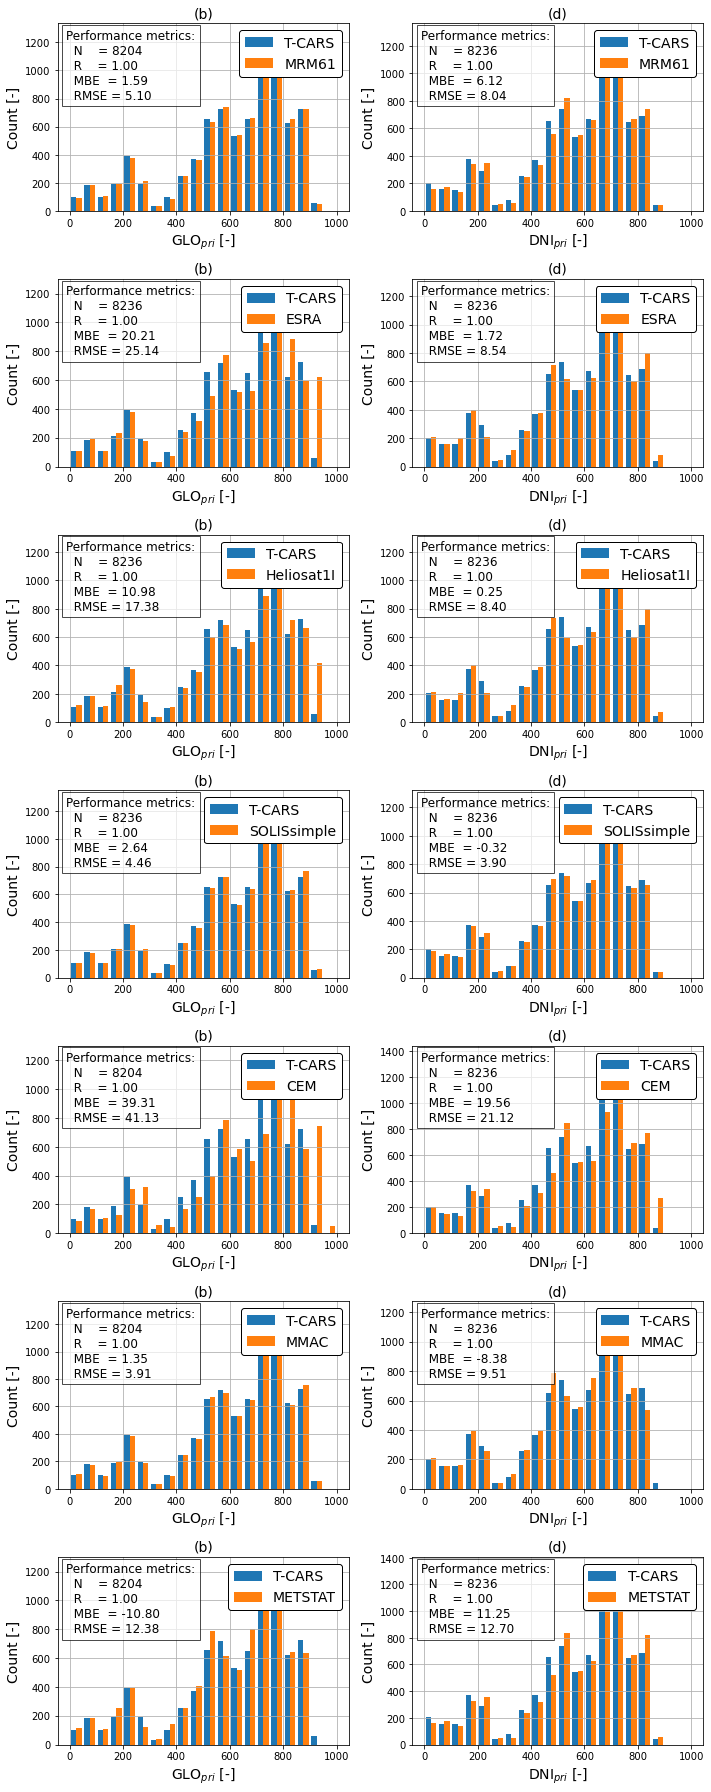

In [5]:
from modules.modules_FIG03 import *
fig,axs = plt.subplots(7,2,figsize=(10,25))#(11,14)
msort=[0,4,2,6,3,1,5]
for m,model in enumerate(models[msort]):
    fig = make_plotqq(fig=fig,
                    X=TGLO0,
                    Y=globals()[f"CGLO0_{model}"],
                    ax=None,ax2=axs[m,0],
                    W='counts', # histogram of number observations
                    title='(a)',
                    title2='(b)',
                    Xlabel='T-CARS',
                    Ylabel=model,
                    Wlabel='Count [-]',
                    Value=r'GLO$_{pri}$ [-]',
                      lalpha=0.7,
                    xlim=(-3,3),
                    xlim2=(0,1000),
                    ylim=(-300,300),
                    qqplot=False,
                    percentiles=np.arange(0.5,100,0.5),
                    histplot=True,
                    metrics_loc=0)

    fig = make_plotqq(fig=fig,
                    X=TDNI0,
                    Y=globals()[f"CDNI0_{model}"],
                    ax=None,ax2=axs[m,1],
                    W='counts', # histogram of number observations
                    title='(c)',
                    title2='(d)',
                    Xlabel='T-CARS',
                    Ylabel=model,
                    Wlabel='Count [-]',
                    Value=r'DNI$_{pri}$ [-]',
                      lalpha=0.7,
                    xlim=(-3,3),
                    xlim2=(0,1000),
                    ylim=(-300,300),
                    qqplot=False,
                    percentiles=np.arange(0.5,100,0.5),
                    histplot=True,
                    metrics_loc=0)
    
plt.tight_layout()